In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from google.colab import drive

In [2]:
drive.flush_and_unmount()
drive.mount('/content/gdrive/', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive/


In [3]:
 cd /content/gdrive/'My Drive'/EBIO5460_sewage_metagenomics/Sewage_shotgun_data/01_taxonomic_data/'01_Filtered_NTU_table_Spatial&Temporal_groups'/

/content/gdrive/.shortcut-targets-by-id/1XYCCvnClFVxMp4IpwPbhaXS2oawJcGmc/EBIO5460_sewage_metagenomics/Sewage_shotgun_data/01_taxonomic_data/01_Filtered_NTU_table_Spatial&Temporal_groups


# Load data

In [15]:
data = pd.read_csv('2020_10_28-Sewer_NTU_table_bacteria_formatted.txt', sep='\t')
data.iloc[0][0] = 'SampleID'
data.columns = data.iloc[0]
data.set_index('taxonomy',inplace=True)
data.drop('taxonomy',inplace=True)
data.drop('SampleID', axis=1, inplace=True)

data = data.transpose()
data.head()

taxonomy,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Comamonadaceae;Comamonas,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Comamonadaceae;Acidovorax,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Aeromonadaceae;Aeromonas,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Acinetobacter,Bacteria;Campylobacterota;Campylobacteria;Campylobacterales;Arcobacteraceae;Arcobacter,Bacteria;Bacteroidota;Bacteroidia;Bacteroidales;Bacteroidaceae;Bacteroides,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Comamonadaceae;NA,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Escherichia-Shigella,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Enterobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;NA,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Citrobacter,Bacteria;Bacteroidota;Bacteroidia;Bacteroidales;Prevotellaceae;Prevotella_9,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Klebsiella,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;NA;NA,Bacteria;Firmicutes;Clostridia;Oscillospirales;Ruminococcaceae;Faecalibacterium,Bacteria;Firmicutes;Clostridia;Lachnospirales;Lachnospiraceae;Blautia,Bacteria;Proteobacteria;Gammaproteobacteria;NA;NA;NA,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;NA;NA,Bacteria;Campylobacterota;Campylobacteria;Campylobacterales;Arcobacteraceae;NA,Bacteria;Bacteroidota;Bacteroidia;Bacteroidales;Tannerellaceae;Parabacteroides,Bacteria;Bacteroidota;Bacteroidia;Flavobacteriales;Weeksellaceae;Cloacibacterium,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Yersiniaceae;Serratia,Bacteria;Firmicutes;Clostridia;Oscillospirales;Ruminococcaceae;Subdoligranulum,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Rhodocyclaceae;Zoogloea,Bacteria;Firmicutes;Clostridia;Lachnospirales;Lachnospiraceae;NA,Bacteria;Firmicutes;Clostridia;Lachnospirales;Lachnospiraceae;Agathobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Alcaligenaceae;Achromobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Neisseriaceae;Uruburuella,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Comamonadaceae;NA,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Aeromonadaceae;Tolumonas,Bacteria;Firmicutes;Negativicutes;Veillonellales-Selenomonadales;Veillonellaceae;Dialister,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Rhodocyclaceae;Dechlorobacter,Bacteria;Firmicutes;Negativicutes;Acidaminococcales;Acidaminococcaceae;Phascolarctobacterium,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Comamonadaceae;Caenimonas,Bacteria;Actinobacteriota;Actinobacteria;Bifidobacteriales;Bifidobacteriaceae;Bifidobacterium,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Stenotrophomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Comamonadaceae;Ottowia,Bacteria;Firmicutes;Clostridia;Lachnospirales;Lachnospiraceae;Lachnoclostridium,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Comamonadaceae;Limnohabitans,...,Bacteria;Bacteroidota;Bacteroidia;Bacteroidales;Prolixibacteraceae;WCHB1-32,Bacteria;Bacteroidota;Bacteroidia;Bacteroidales;Rikenellaceae;dgA-11_gut_group,Bacteria;Bacteroidota;Bacteroidia;Chitinophagales;Chitinophagaceae;Niabella,Bacteria;Bacteroidota;Bacteroidia;Flavobacteriales;Weeksellaceae;Apibacter,Bacteria;Calditrichota;Calditrichia;Calditrichales;Calditrichaceae;JdFR-76,Bacteria;Campylobacterota;Campylobacteria;Campylobacterales;Arcobacteraceae;Halarcobacter,Bacteria;Firmicutes;Clostridia;Lachnospirales;Lachnospiraceae;GCA-900066755,Bacteria;Firmicutes;Clostridia;Oscillospirales;Ethanoligenenaceae;Acetanaerobacterium,Bacteria;Firmicutes;Clostridia;Oscillospiral

In [18]:
cd /content/gdrive/'My Drive'/EBIO5460_sewage_metagenomics/'Group 2: Temporal'/

/content/gdrive/.shortcut-targets-by-id/1XYCCvnClFVxMp4IpwPbhaXS2oawJcGmc/EBIO5460_sewage_metagenomics/Group 2: Temporal


In [21]:
metadata = pd.read_csv("MetaData.csv")
metadata.set_index('SampleID',inplace=True)

excluded = [] 
for sample in data.index:
  if sample not in metadata.index:
    print(sample)
    excluded.append(sample)

data.drop(labels=excluded,
          inplace=True)

HAL_10
HAL_12
HAL_13
HAL_15
HAL_17
HAL_20
REG_12
REG_13
REG_15
REG_17
REG_19
REG_20
REG_5
REG_6
REG_8


In [22]:
print(data.shape, metadata.shape)

(173, 1087) (173, 22)


# Find taxa of interest

In [42]:
legs = []
acins = []
for tax in data.columns:
  if "Legionella" in tax:
    legs.append(tax)
  elif "Acinetobacter" in tax:
    acins.append(tax)

In [43]:
legs

['Bacteria;Proteobacteria;Gammaproteobacteria;Legionellales;Legionellaceae;Legionella',
 'Bacteria;Proteobacteria;Gammaproteobacteria;Legionellales;Legionellaceae;NA',
 'Bacteria;Proteobacteria;Gammaproteobacteria;Legionellales;Legionellaceae;NA']

Going to stick with just the first tax for Legionellaceae because we have higher resolution.

In [48]:
leg = legs[0]

In [44]:
acins

['Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Acinetobacter']

In [49]:
acin = acins[0]

# Look at how many locations had initially elevated values

In [68]:
of_interest = pd.concat([data[[leg, acin]],
                         metadata[["Location","DaysSince"]]],
                        axis=1)
of_interest[leg] = of_interest[leg].astype(float)
of_interest[acin] = of_interest[acin].astype(float)
of_interest["DaysSince"] = of_interest["DaysSince"].astype(int)

In [78]:
leg_dec_locs = []
acin_dec_locs = []

for loc in of_interest["Location"].unique():

  loc_initial = of_interest.loc[(of_interest["Location"] == loc) & 
                                (of_interest["DaysSince"] <= 4)]

  # spearman r of 1 would indicate that the rel abundance decreased
  # across all 3 timepoints. Some are showing as 0.999999,
  # so I'm using 0.95 instead of 1
  leg_spear = stats.spearmanr(loc_initial[leg], loc_initial["DaysSince"],
                              nan_policy="omit")
  if leg_spear[0] < -0.95:
    leg_dec_locs.append(loc)
    
  acin_spear = stats.spearmanr(loc_initial[acin], loc_initial["DaysSince"],
                              nan_policy="omit")
  if acin_spear[0] < -0.95:
    acin_dec_locs.append(loc)


num_sites = len(of_interest["Location"].unique())

print(f"{len(leg_dec_locs)} out of {num_sites} sites saw a decrease in Legionella across all timepoints during the first 4 days.")
print("The sites that decreased were:", leg_dec_locs)

print(f"\n{len(acin_dec_locs)} out of {num_sites} sites saw a decrease in Acinetobacter across all timepoints during the first 4 days.")
print("The sites that decreased were:", acin_dec_locs)

10 out of 15 sites saw a decrease in Legionella across all timepoints during the first 4 days.
The sites that decreased were: ['Baker', 'Baseline', 'Brackett_Aden', 'Cockerell', 'Crossman_Reed', 'Darley', 'Lacrosse', 'Stearns', 'Weber', 'Willard']

7 out of 15 sites saw a decrease in Acinetobacter across all timepoints during the first 4 days.
The sites that decreased were: ['Baker', 'Cockerell', 'Crossman_Reed', 'Darley', 'Lacrosse', 'Stearns', 'Willard']


# Plotting

In [86]:
decreasing_leg_df = of_interest.loc[of_interest["Location"].apply(lambda x: x in leg_dec_locs)]
of_interest["Legionella decreases"] = of_interest["Location"].apply(lambda x: x in leg_dec_locs)

decreasing_acin_df = of_interest.loc[of_interest["Location"].apply(lambda x: x in acin_dec_locs)]
of_interest["Acinetobacter decreases"] = of_interest["Location"].apply(lambda x: x in acin_dec_locs)

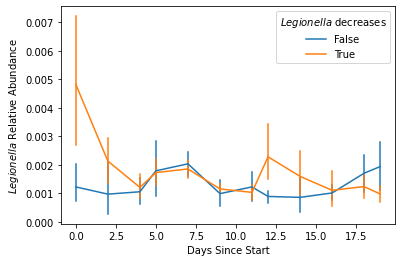

In [94]:
ax = sns.lineplot(x="DaysSince",
                  y=leg,
                  hue="Legionella decreases",
                  data=of_interest,
                  err_style="bars")

ax.set_ylabel(r"$Legionella$ Relative Abundance")
ax.set_xlabel("Days Since Start")
ax.legend(title=r"$Legionella$ decreases")

plt.show()

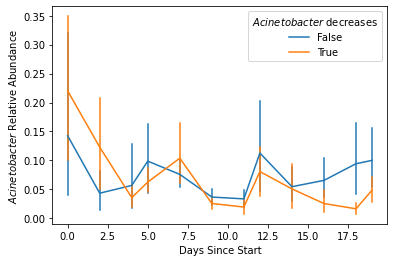

In [93]:
ax = sns.lineplot(x="DaysSince",
                  y=acin,
                  hue="Acinetobacter decreases",
                  data=of_interest,
                  err_style="bars")

ax.set_ylabel(r"$Acinetobacter$ Relative Abundance")
ax.set_xlabel("Days Since Start")
ax.legend(title=r"$Acinetobacter$ decreases")

plt.show()

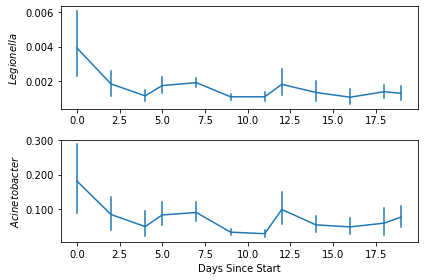

In [115]:
fig, axes = plt.subplots(2,1)

ax = sns.lineplot(x="DaysSince",
                  y=leg,
                  data=of_interest,
                  err_style="bars",
                  ax=axes[0])

ax.set_ylabel(r"$Legionella$")
ax.set_xlabel("")

ax = sns.lineplot(x="DaysSince",
                  y=acin,
                  data=of_interest,
                  err_style="bars",
                  ax=axes[1])

ax.set_ylabel(r"$Acinetobacter$")
ax.set_xlabel("Days Since Start")
ax.set_yticklabels(["0.0","0.100", "0.200", "0.300"])

plt.tight_layout()
plt.show()

In [102]:
melted_leg_acin = pd.melt(of_interest[[leg, acin, "DaysSince"]], 
                          id_vars="DaysSince")
melted_leg_acin.columns = ["Days Since Start", "Full tax", "Relative Abundance"]
melted_leg_acin["Genus"] = melted_leg_acin["Full tax"].apply(lambda x: x.split(";")[-1])

In [103]:
melted_leg_acin

,Days Since Start,Full tax,Relative Abundance,Genus
0,0,Bacteria;Proteobacteria;Gammaproteobacteria;Le...,0.001369,Legionella
1,9,Bacteria;Proteobacteria;Gammaproteobacteria;Le...,0.000990,Legionella
2,11,Bacteria;Proteobacteria;Gammaproteobacteria;Le...,0.000865,Legionella
3,12,Bacteria;Proteobacteria;Gammaproteobacteria;Le...,0.001498,Legionella
4,14,Bacteria;Proteobacteria;Gammaproteobacteria;Le...,0.000268,Legionella
...,...,...,...,...
341,19,Bacteria;Proteobacteria;Gammaproteobacteria;Ps...,0.083799,Acinetobacter
342,2,Bacteria;Proteobacteria;Gammaproteobacteria;Ps...,0.198396,Acinetobacter
343,4,Bacteria;Proteobacteria;Gammaproteobacteria;Ps...,0.027883,Acinetobacter
344,5,Bacteria;Proteobacteria;Gammaproteobacteria;Ps...,0.064295,Acinetobacter


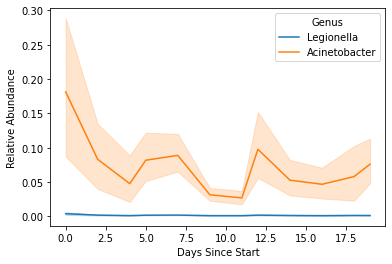

In [104]:
sns.lineplot(x="Days Since Start",
             y="Relative Abundance",
             hue="Genus",
             data=melted_leg_acin)